In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,OneHotEncoder,LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score,mean_squared_error

In [2]:
train = pd.read_excel("data/train.xlsx")

In [3]:
train.head(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
5,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,non-stop,No info,3873
6,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087
7,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,08:00,05:05 02 Mar,21h 5m,1 stop,No info,22270
8,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,08:55,10:25 13 Mar,25h 30m,1 stop,In-flight meal not included,11087
9,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,11:25,19:15,7h 50m,1 stop,No info,8625


In [4]:
train.shape

(10683, 11)

In [4]:
train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
# As there were less null values, decided to drop those rows
train.dropna(inplace=True)

In [6]:
train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [7]:
train["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [8]:
train.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [9]:
train["Additional_Info"].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
2 Long layover                     1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

In [11]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [7]:
# Turned columns with date and time to datetime
def object_to_datetime(df, col):
    df[col] = pd.to_datetime(df[col])

In [8]:
for i in ['Date_of_Journey','Dep_Time','Arrival_Time']:
    object_to_datetime(train,i)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10682 non-null  object        
 1   Date_of_Journey  10682 non-null  datetime64[ns]
 2   Source           10682 non-null  object        
 3   Destination      10682 non-null  object        
 4   Route            10682 non-null  object        
 5   Dep_Time         10682 non-null  datetime64[ns]
 6   Arrival_Time     10682 non-null  datetime64[ns]
 7   Duration         10682 non-null  object        
 8   Total_Stops      10682 non-null  object        
 9   Additional_Info  10682 non-null  object        
 10  Price            10682 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 1001.4+ KB


In [16]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2021-02-18 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-02-18 05:50:00,2021-02-18 13:15:00,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2021-02-18 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2021-02-18 18:05:00,2021-02-18 23:30:00,5h 25m,1 stop,No info,6218
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2021-02-18 16:50:00,2021-02-18 21:35:00,4h 45m,1 stop,No info,13302


In [10]:
# Extracting day and month from Date_of_Journey column
def day_and_month(df,col):
    df[col+'_day'] = df[col].dt.day
    df[col+'_month'] = df[col].dt.month

In [11]:
day_and_month(train,"Date_of_Journey")

train.drop(['Date_of_Journey'],axis=1,inplace=True)

In [15]:
train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_day,Date_of_Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-03-08 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-03-08 05:50:00,2021-03-08 13:15:00,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-03-08 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-03-08 18:05:00,2021-03-08 23:30:00,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-03-08 16:50:00,2021-03-08 21:35:00,4h 45m,1 stop,No info,13302,3,1


In [12]:
# Extracting hour and minutes from Dep_Time and Arrival_Time columns
def hour_and_minute(df,col):
    df[col+'_hour'] = df[col].dt.hour
    df[col+'_minute'] = df[col].dt.minute

In [13]:
for i in ['Dep_Time', 'Arrival_Time']:
    hour_and_minute(train,i)

train.drop(['Dep_Time', 'Arrival_Time'],axis=1,inplace=True)

In [18]:
train.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [14]:
# Duration was in hours(2h 50m), converted them to minutes(170 mins)
def clean_duration(df,col):
    for i in range(len(df)):
        a = df[col].loc[i].split(' ')
        if(len(a) == 2):
            hours = int(re.split('(\D+)',a[0])[0])
            minutes = int(re.split('(\D+)',a[1])[0])
            total_mins =(hours*60)+minutes
            df[col][i] = total_mins
        else:
            hours = int(re.split('(\D+)',a[0])[0])
            total_mins =(hours*60)
            df[col][i] = total_mins    

In [15]:
train.reset_index(inplace=True)
train.drop(["index"],axis=1,inplace=True)
clean_duration(train,"Duration")
train.rename(columns={"Duration":"Duration_in_mins"},inplace=True)

In [16]:
train.dtypes

Airline                  object
Source                   object
Destination              object
Route                    object
Duration_in_mins         object
Total_Stops              object
Additional_Info          object
Price                     int64
Date_of_Journey_day       int64
Date_of_Journey_month     int64
Dep_Time_hour             int64
Dep_Time_minute           int64
Arrival_Time_hour         int64
Arrival_Time_minute       int64
dtype: object

In [17]:
# Converted Duration column to int as it was in object type
train["Duration_in_mins"] = train["Duration_in_mins"].astype('int64')

In [23]:
train.head()

,Airline,Source,Destination,Route,Duration_in_mins,Total_Stops,Additional_Info,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35


In [18]:
# Dropped Additional info as majority was No info
train.drop(['Route','Additional_Info'],axis=1,inplace=True)

In [19]:
num = train.select_dtypes(exclude='object').columns
cat = train.select_dtypes(include='object').columns
print(num,'\n',cat)

Index(['Duration_in_mins', 'Price', 'Date_of_Journey_day',
       'Date_of_Journey_month', 'Dep_Time_hour', 'Dep_Time_minute',
       'Arrival_Time_hour', 'Arrival_Time_minute'],
      dtype='object') 
 Index(['Airline', 'Source', 'Destination', 'Total_Stops'], dtype='object')


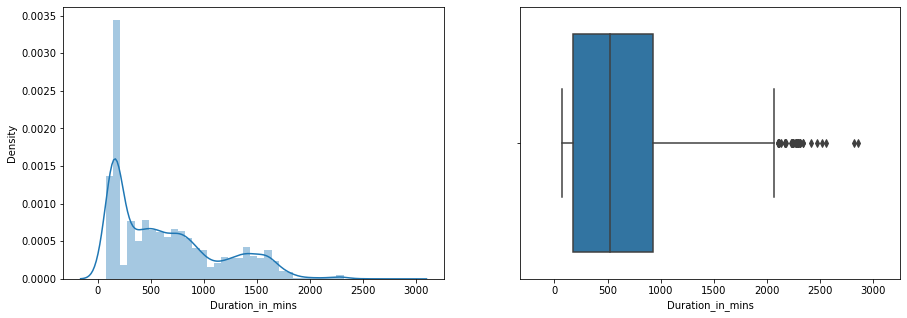

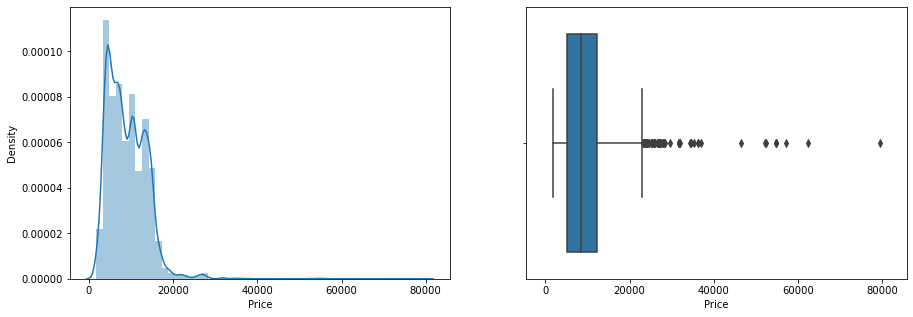

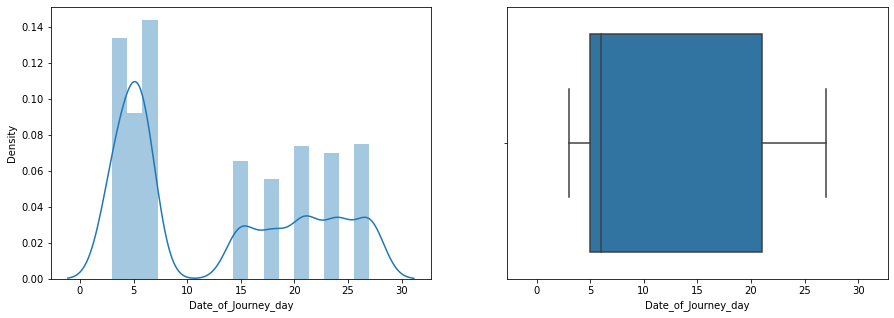

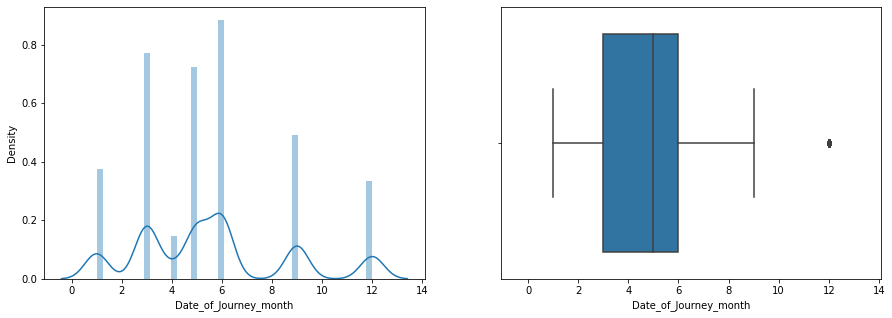

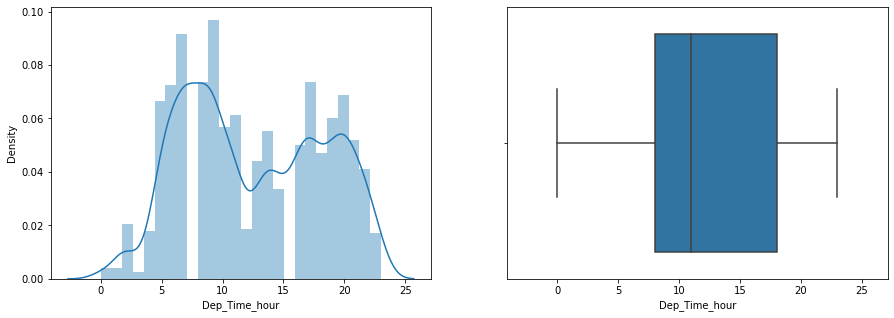

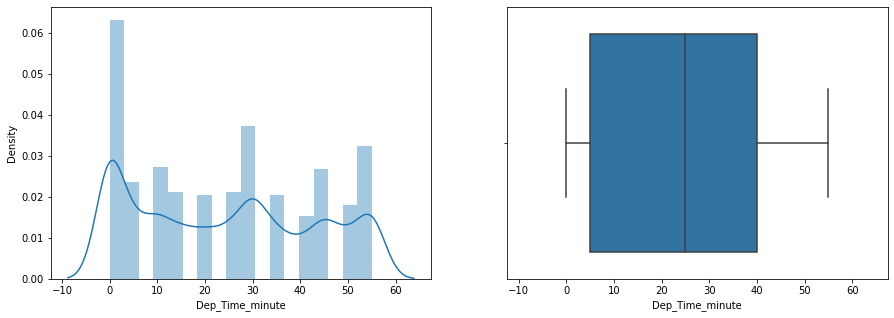

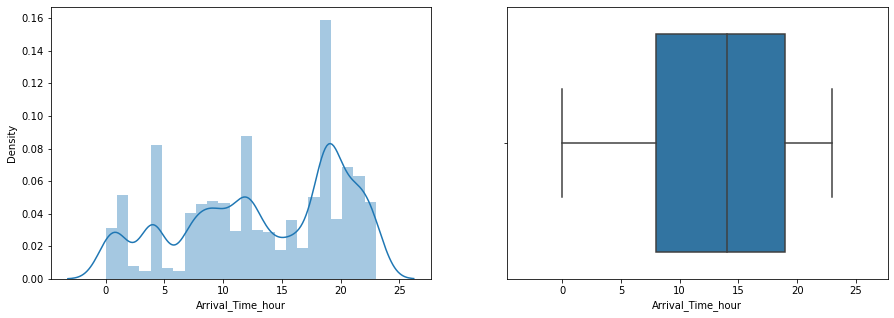

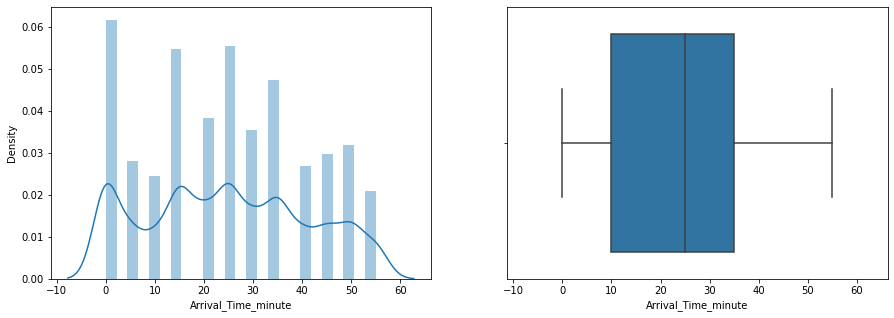

In [31]:
for col in num:    
    fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(15,5))
    sns.distplot(train[col],ax=ax1)
#     plt.show()
    sns.boxplot(train[col],ax=ax2)
#     plt.show()

In [32]:
train.describe()

,Duration_in_mins,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,643.048118,9087.214567,12.682925,5.534731,12.491013,24.409287,13.349186,24.690601
std,507.803454,4611.548810,8.803800,2.987626,5.748820,18.767801,6.859317,16.506808
min,75.000000,1759.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,170.000000,5277.000000,5.000000,3.000000,8.000000,5.000000,8.000000,10.000000
50%,520.000000,8372.000000,6.000000,5.000000,11.000000,25.000000,14.000000,25.000000
75%,930.000000,12373.000000,21.000000,6.000000,18.000000,40.000000,19.000000,35.000000
max,2860.000000,79512.000000,27.000000,12.000000,23.000000,55.000000,23.000000,55.000000


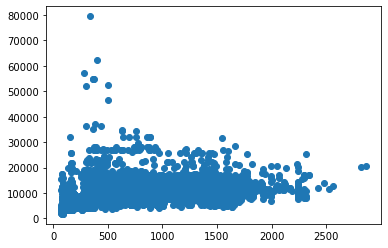

In [33]:
plt.scatter(train["Duration_in_mins"],train["Price"])

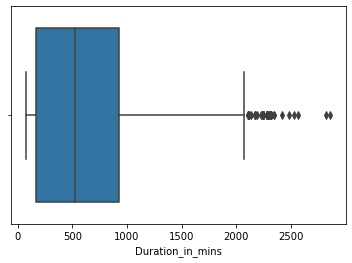

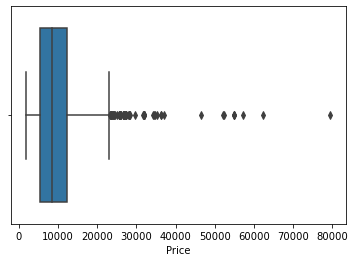

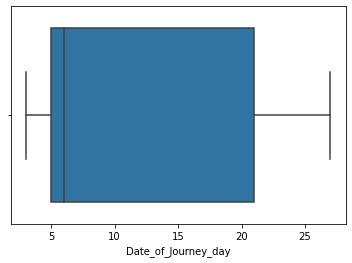

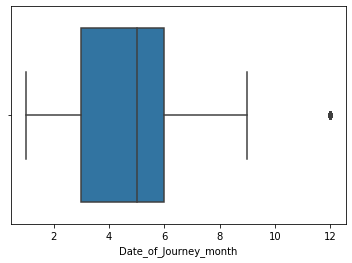

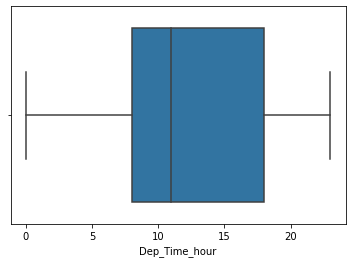

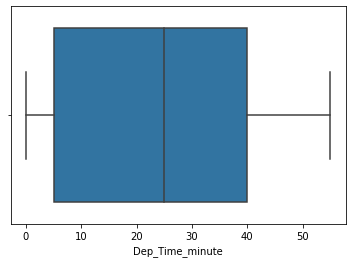

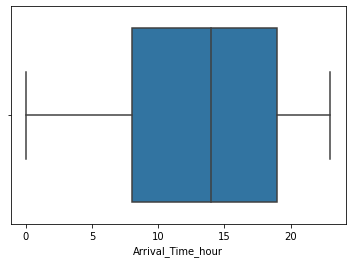

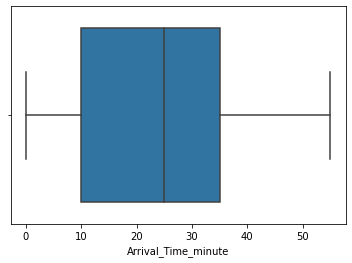

In [35]:
for col in num:
    sns.boxplot(train1[col])
    plt.show()

In [25]:
def detect_outliers(df):
    outliers = pd.DataFrame(columns=["Feature"])
    num = df.select_dtypes(exclude="object")
    for col in num:
        q3 = df[col].quantile(0.75)
        q1 = df[col].quantile(0.25)
        iqr = q3-q1
        fence_low = q1 - (1.5*iqr)
        fence_high = q3 + (1.5*iqr)
#         print(col,fence_low,fence_high)
        outliers = outliers.append({'Feature':col,'Number of Outliers':df.loc[(df[col] < fence_low) | (df[col] > fence_high)].shape[0]},ignore_index=True)
    return outliers

In [26]:
detect_outliers(train)

,Feature,Number of Outliers
0,Duration_in_mins,73.0
1,Price,94.0
2,Date_of_Journey_day,0.0
3,Date_of_Journey_month,957.0
4,Dep_Time_hour,0.0
5,Dep_Time_minute,0.0
6,Arrival_Time_hour,0.0
7,Arrival_Time_minute,0.0


In [20]:
cat

Index(['Airline', 'Source', 'Destination', 'Total_Stops'], dtype='object')

In [27]:
train.head()

,Airline,Source,Destination,Route,Duration_in_mins,Total_Stops,Additional_Info,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35


In [25]:
train[train['Airline']=='Trujet']

,Airline,Source,Destination,Duration_in_mins,Total_Stops,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
2878,Trujet,Mumbai,Hyderabad,195,1 stop,4140,3,6,13,5,16,20


In [ ]:
# train.drop(2878,inplace=True)

In [29]:
lb = LabelEncoder()
train['Total_Stops'] = lb.fit_transform(train['Total_Stops'])

In [31]:
train = pd.get_dummies(train)

In [32]:
train.head()

,Duration_in_mins,Total_Stops,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Airline_Air Asia,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,170,4,3897,24,3,22,20,1,10,0,...,0,0,0,0,0,0,0,0,0,1
1,445,1,7662,5,1,5,50,13,15,0,...,0,0,1,0,1,0,0,0,0,0
2,1140,1,13882,6,9,9,25,4,25,0,...,0,1,0,0,0,1,0,0,0,0
3,325,0,6218,5,12,18,5,23,30,0,...,0,0,1,0,1,0,0,0,0,0
4,285,0,13302,3,1,16,50,21,35,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# a = []
# for col in cat:
#     unq_values = train[col].unique()
#     a.extend(list(unq_values))

In [66]:
# a

In [23]:
# encoder = OneHotEncoder(handle_unknown='ignore')
# encoded_train = pd.DataFrame(encoder.fit_transform(train[cat]).toarray(),columns=a)

In [24]:
# train_new =  pd.merge(train[num],encoded_train,left_index=True,right_index=True)

In [26]:
train_new.head()

,Duration_in_mins,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,IndiGo,Air India,...,No info,In-flight meal not included,No check-in baggage included,1 Short layover,No Info,1 Long layover,Change airports,Business class,Red-eye flight,2 Long layover
0,170,3897,24,3,22,20,1,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,445,7662,5,1,5,50,13,15,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1140,13882,6,9,9,25,4,25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,325,6218,5,12,18,5,23,30,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,285,13302,3,1,16,50,21,35,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
num

Index(['Duration_in_mins', 'Price', 'Date_of_Journey_day',
       'Date_of_Journey_month', 'Dep_Time_hour', 'Dep_Time_minute',
       'Arrival_Time_hour', 'Arrival_Time_minute'],
      dtype='object')

In [34]:
num = num.drop('Price')

In [36]:
scaler = MinMaxScaler()
train[num] = scaler.fit_transform(train[num])

In [27]:
train_new.head()

,Duration_in_mins,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,IndiGo,Air India,Jet Airways,...,No info,In-flight meal not included,No check-in baggage included,1 Short layover,No Info,1 Long layover,Change airports,Business class,Red-eye flight,2 Long layover
0,0.034111,0.875000,0.181818,0.956522,0.363636,0.043478,0.181818,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.132855,0.083333,0.000000,0.217391,0.909091,0.565217,0.272727,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.382406,0.125000,0.727273,0.391304,0.454545,0.173913,0.454545,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.089767,0.083333,1.000000,0.782609,0.090909,1.000000,0.545455,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.075404,0.000000,0.000000,0.695652,0.909091,0.913043,0.636364,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
# train = pd.get_dummies(train)

In [37]:
train.head()

,Duration_in_mins,Total_Stops,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Airline_Air Asia,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.034111,4,3897,0.875000,0.181818,0.956522,0.363636,0.043478,0.181818,0,...,0,0,0,0,0,0,0,0,0,1
1,0.132855,1,7662,0.083333,0.000000,0.217391,0.909091,0.565217,0.272727,0,...,0,0,1,0,1,0,0,0,0,0
2,0.382406,1,13882,0.125000,0.727273,0.391304,0.454545,0.173913,0.454545,0,...,0,1,0,0,0,1,0,0,0,0
3,0.089767,0,6218,0.083333,1.000000,0.782609,0.090909,1.000000,0.545455,0,...,0,0,1,0,1,0,0,0,0,0
4,0.075404,0,13302,0.000000,0.000000,0.695652,0.909091,0.913043,0.636364,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
X = train.drop("Price",axis=1)
y = train["Price"]

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [41]:
linear = LinearRegression()

In [42]:
linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
y_pred = linear.predict(X_test)

In [44]:
linear.score(X_train,y_train)

0.601054574012827

In [45]:
r2_score(y_test,y_pred)

0.5503127473930964

In [46]:
rf = RandomForestRegressor()

In [47]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
y_pred = rf.predict(X_test)

In [49]:
print(r2_score(y_test,y_pred))

0.8072615402072415


<AxesSubplot:xlabel='Price', ylabel='Density'>

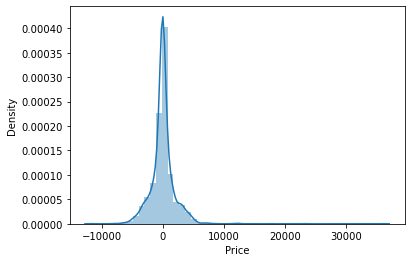

In [50]:
sns.distplot(y_test-y_pred)

In [54]:
test = pd.read_excel('data/test.xlsx')

In [52]:
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [55]:
test.dropna(inplace=True)

In [57]:
for i in ['Date_of_Journey','Dep_Time','Arrival_Time']:
    object_to_datetime(test,i)

In [58]:
day_and_month(test,"Date_of_Journey")

test.drop(['Date_of_Journey'],axis=1,inplace=True)

In [59]:
for i in ['Dep_Time', 'Arrival_Time']:
    hour_and_minute(test,i)

test.drop(['Dep_Time', 'Arrival_Time'],axis=1,inplace=True)

In [60]:
test.reset_index(inplace=True,drop=True)
clean_duration(test,"Duration")
test.rename(columns={"Duration":"Duration_in_mins"},inplace=True)
test["Duration_in_mins"] = test["Duration_in_mins"].astype('int64')

In [61]:
test.drop(['Route','Additional_Info'],axis=1,inplace=True)

In [63]:
test['Total_Stops'] = lb.transform(test['Total_Stops'])

In [64]:
test = pd.get_dummies(test)

In [65]:
test[num] = scaler.transform(test[num])

In [70]:
train.to_csv('treated_train.csv',index=False)
test.to_csv('treated_test.csv',index=False)